In [1]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import StandardScaler

In [2]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])
        self.counter = 0

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w,a)+b)
        return a

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))  # mean-squared error
        return total_score/X.shape[0]
    
    def score_vector(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))
        total_score=total_score/X.shape[0] # mean-squared error
        return (1/(1+total_score))

    def accuracy(self, X, y):
        accuracy = 0
        for i in range(X.shape[0]):
            output = (self.feedforward(X[i].reshape(-1,1))).reshape(-1)
            condition = True
            for j in range(len(output)):
                output[j] = round(output[j])
            for j in range(len(output)):
                if(output[j]!=y[i][j]):
                    condition = False
                    break
            if condition:
                accuracy += 1
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

In [3]:
class NN_ABC_Algo:

    def __init__(self, n_pops, net_size, X, y, X_test, y_test):
        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.X = X[:]
        self.y = y[:]
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        self.accuracy_train = []
        self.accuracy_test = []
        self.limit = self.n_pops
        self.best = Network(self.net_size)
    
    def get_random_point(self, type):
        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self,Xc,yc):
        return [net.score(Xc, yc) for net in self.nets]

    def get_all_scores_vector(self,Xc,yc):
        return [net.score_vector(Xc, yc) for net in self.nets]

    def get_all_accuracy(self,Xc,yc):
        return [net.accuracy(Xc, yc) for net in self.nets]
    
    def initialization_phase(self):
        for i in range(self.n_pops):
            weight = copy.deepcopy(self.nets[i].weights)
            for x in range(len(weight)):
                for y in range(len(weight[x])):
                    for z in range(len(weight[x][y])):
                        weight[x][y][z]=self.nets[i].weights[x][y].min() + np.random.rand()*(self.nets[i].weights[x][y].max()-self.nets[i].weights[x][y].min())
            self.nets[i].weights = copy.deepcopy(weight)
            biases = copy.deepcopy(self.nets[i].biases)
            for x in range(len(biases)):
                for y in range(len(biases[x])):
                    for z in range(len(biases[x][y])):
                        biases[x][y][z]=self.nets[i].biases[x].min() + np.random.rand()*(self.nets[i].biases[x].max()-self.nets[i].biases[x].min())
            self.nets[i].biases = copy.deepcopy(biases)

    def employeed_phase(self,Xc,yc):
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            r = list(range(0,i)) + list(range(i+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[i])
            for t in range(1):
                # get some random points
                layer1, point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[layer1][point1] = nn.biases[layer1][point1] + fi1*(nn.biases[layer1][point1]-self.nets[coceg].biases[layer1][point1])
                layer2, point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[layer2][point2] = nn.weights[layer2][point2] + fi2*(nn.weights[layer2][point2]-self.nets[coceg].weights[layer2][point2])
            if(nn.score_vector(Xc,yc)>nets[i].score_vector(Xc,yc)):
                nn.counter = 0
                nets[i] = copy.deepcopy(nn)
            else:
                nets[i].counter += 1
        self.nets = copy.deepcopy(nets)
        
    def onlooked_phase(self,Xc,yc):
        all_scores_vector = self.get_all_scores_vector(Xc,yc)
        sum = np.sum(all_scores_vector)
        probability = all_scores_vector/sum
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            index_solution = np.random.choice(list(range(self.n_pops)),p=probability)
            r = list(range(0,index_solution)) + list(range(index_solution+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[index_solution])
            for t in range(1):
                # get some random points
                layer1, point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[layer1][point1] = nn.biases[layer1][point1] + fi1*(nn.biases[layer1][point1]-self.nets[coceg].biases[layer1][point1])
                layer2, point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[layer2][point2] = nn.weights[layer2][point2] + fi2*(nn.weights[layer2][point2]-self.nets[coceg].weights[layer2][point2])
            if(nn.score_vector(Xc,yc)>nets[index_solution].score_vector(Xc,yc)):
                nn.counter = 0
                nets[index_solution] = copy.deepcopy(nn)
            else:
                nets[index_solution].counter += 1
        self.nets = copy.deepcopy(nets)

    def scout_phase(self):
        for i in range(self.n_pops):
            if self.nets[i].counter > self.limit:
                weight = copy.deepcopy(self.nets[i].weights)
                for x in range(len(weight)):
                    for y in range(len(weight[x])):
                        for z in range(len(weight[x][y])):
                            weight[x][y][z]=self.nets[i].weights[x][y].min() + np.random.rand()*(self.nets[i].weights[x][y].max()-self.nets[i].weights[x][y].min())
                self.nets[i].weights = copy.deepcopy(weight)
                biases = copy.deepcopy(self.nets[i].biases)
                for x in range(len(biases)):
                    for y in range(len(biases[x])):
                        for z in range(len(biases[x][y])):
                            biases[x][y][z]=self.nets[i].biases[x].min() + np.random.rand()*(self.nets[i].biases[x].max()-self.nets[i].biases[x].min())
                self.nets[i].biases = copy.deepcopy(biases)
                self.nets[i].counter = 0
                
    def sort_nets(self,Xc,yc):
        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores(Xc,yc)))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]
        self.nets = copy.deepcopy(score_list)
        if(self.best.accuracy(self.X,self.y)<self.nets[0].accuracy(self.X,self.y)):
            self.best = copy.deepcopy(self.nets[0])

    def evolve(self):
        start_time = time.time()
        self.initialization_phase()
        for t in range(25):
            self.accuracy_train.append(self.best.accuracy(self.X,self.y))
            self.accuracy_test.append(self.best.accuracy(self.X_test,self.y_test))
            for i in range(20):
                j1=i*40
                j2=(1+i)*40
                Xc=self.X[j1:j2,:]
                yc=self.y[j1:j2,:]
                for k in range(25):  
                    self.employeed_phase(Xc,yc)
                    self.onlooked_phase(Xc,yc)
                    self.scout_phase()
                    self.sort_nets(Xc,yc)
                print("Current iteration : {}, batch : {}".format(t+1,i+1))
                print("Time taken by far : %.1f seconds" % (time.time() - start_time))
                print("Current top member's network score: %.5f " % self.best.score(self.X,self.y))
                print("Current top member's network accuracy: %.2f%%\n" % self.best.accuracy(self.X,self.y))

In [4]:
df = pd.read_csv("../Data/data_(8-8).csv")

In [5]:
X = df.iloc[:800, :8].values
y = df.iloc[:800, 8:16].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = df.iloc[800:1000, :8].values
y_test = df.iloc[800:1000, 8:16].values
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [6]:
N_POPS = 100
NET_SIZE = [8,8,8]
nnabc = NN_ABC_Algo(N_POPS, NET_SIZE, X, y, X_test, y_test)
nnabc.evolve()

Current iteration : 1, batch : 1
Time taken by far : 33.6 seconds
Current top member's network score: 1.62324 
Current top member's network accuracy: 6.75%

Current iteration : 1, batch : 2
Time taken by far : 71.2 seconds
Current top member's network score: 1.47098 
Current top member's network accuracy: 6.88%

Current iteration : 1, batch : 3
Time taken by far : 108.2 seconds
Current top member's network score: 1.42276 
Current top member's network accuracy: 13.88%

Current iteration : 1, batch : 4
Time taken by far : 145.8 seconds
Current top member's network score: 1.25786 
Current top member's network accuracy: 16.75%

Current iteration : 1, batch : 5
Time taken by far : 181.3 seconds
Current top member's network score: 1.40161 
Current top member's network accuracy: 33.25%

Current iteration : 1, batch : 6
Time taken by far : 214.7 seconds
Current top member's network score: 1.40161 
Current top member's network accuracy: 33.25%

Current iteration : 1, batch : 7
Time taken by far

C:\Users\nguye\AppData\Local\Temp/ipykernel_12056/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Current iteration : 1, batch : 9
Time taken by far : 320.2 seconds
Current top member's network score: 1.40161 
Current top member's network accuracy: 33.25%

Current iteration : 1, batch : 10
Time taken by far : 355.3 seconds
Current top member's network score: 1.20465 
Current top member's network accuracy: 43.50%

Current iteration : 1, batch : 11
Time taken by far : 390.8 seconds
Current top member's network score: 1.20465 
Current top member's network accuracy: 43.50%

Current iteration : 1, batch : 12
Time taken by far : 426.0 seconds
Current top member's network score: 1.20465 
Current top member's network accuracy: 43.50%

Current iteration : 1, batch : 13
Time taken by far : 462.6 seconds
Current top member's network score: 0.89175 
Current top member's network accuracy: 46.75%

Current iteration : 1, batch : 14
Time taken by far : 501.0 seconds
Current top member's network score: 0.89175 
Current top member's network accuracy: 46.75%

Current iteration : 1, batch : 15
Time ta

Current iteration : 4, batch : 1
Time taken by far : 2337.6 seconds
Current top member's network score: 0.63195 
Current top member's network accuracy: 65.75%

Current iteration : 4, batch : 2
Time taken by far : 2374.7 seconds
Current top member's network score: 0.72864 
Current top member's network accuracy: 69.00%

Current iteration : 4, batch : 3
Time taken by far : 2411.2 seconds
Current top member's network score: 0.73310 
Current top member's network accuracy: 70.12%

Current iteration : 4, batch : 4
Time taken by far : 2448.2 seconds
Current top member's network score: 0.73310 
Current top member's network accuracy: 70.12%

Current iteration : 4, batch : 5
Time taken by far : 2484.8 seconds
Current top member's network score: 0.73310 
Current top member's network accuracy: 70.12%

Current iteration : 4, batch : 6
Time taken by far : 2521.5 seconds
Current top member's network score: 0.73310 
Current top member's network accuracy: 70.12%

Current iteration : 4, batch : 7
Time ta

Current iteration : 6, batch : 13
Time taken by far : 4331.6 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 14
Time taken by far : 4370.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 15
Time taken by far : 4409.2 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 16
Time taken by far : 4448.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 17
Time taken by far : 4486.6 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 18
Time taken by far : 4524.5 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 6, batch : 19


Current iteration : 9, batch : 5
Time taken by far : 6346.4 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 6
Time taken by far : 6385.0 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 7
Time taken by far : 6424.2 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 8
Time taken by far : 6463.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 9
Time taken by far : 6502.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 10
Time taken by far : 6541.3 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 9, batch : 11
Time 

Current iteration : 11, batch : 16
Time taken by far : 8287.2 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 11, batch : 17
Time taken by far : 8319.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 11, batch : 18
Time taken by far : 8351.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 11, batch : 19
Time taken by far : 8384.8 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 11, batch : 20
Time taken by far : 8417.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 12, batch : 1
Time taken by far : 8449.5 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 12, batch

Current iteration : 14, batch : 7
Time taken by far : 9949.2 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, batch : 8
Time taken by far : 9982.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, batch : 9
Time taken by far : 10018.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, batch : 10
Time taken by far : 10054.8 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, batch : 11
Time taken by far : 10088.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, batch : 12
Time taken by far : 10121.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 14, bat

Current iteration : 16, batch : 18
Time taken by far : 11534.5 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 16, batch : 19
Time taken by far : 11560.6 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 16, batch : 20
Time taken by far : 11586.3 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 17, batch : 1
Time taken by far : 11612.6 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 17, batch : 2
Time taken by far : 11640.2 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 17, batch : 3
Time taken by far : 11666.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 17, b

Current iteration : 19, batch : 9
Time taken by far : 12905.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19, batch : 10
Time taken by far : 12932.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19, batch : 11
Time taken by far : 12961.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19, batch : 12
Time taken by far : 12988.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19, batch : 13
Time taken by far : 13015.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19, batch : 14
Time taken by far : 13041.6 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 19,

Current iteration : 21, batch : 20
Time taken by far : 14464.4 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, batch : 1
Time taken by far : 14497.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, batch : 2
Time taken by far : 14529.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, batch : 3
Time taken by far : 14564.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, batch : 4
Time taken by far : 14598.1 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, batch : 5
Time taken by far : 14629.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 22, bat

Current iteration : 24, batch : 11
Time taken by far : 16076.7 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24, batch : 12
Time taken by far : 16110.0 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24, batch : 13
Time taken by far : 16143.4 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24, batch : 14
Time taken by far : 16177.9 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24, batch : 15
Time taken by far : 16212.0 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24, batch : 16
Time taken by far : 16245.4 seconds
Current top member's network score: 0.62911 
Current top member's network accuracy: 79.00%

Current iteration : 24

In [13]:
nnabc.best.accuracy(X,y)

C:\Users\nguye\AppData\Local\Temp/ipykernel_12056/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


79.0

In [14]:
nnabc.best.accuracy(X_test,y_test)

C:\Users\nguye\AppData\Local\Temp/ipykernel_12056/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


75.0

In [7]:
accuracy_train = np.array(nnabc.accuracy_train)
accuracy_test = np.array(nnabc.accuracy_test)

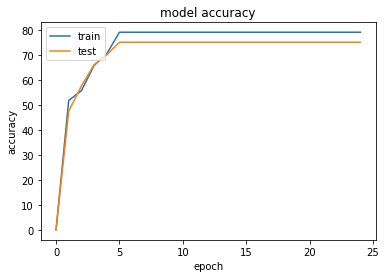

In [9]:
from matplotlib import pyplot as plt
plt.plot(accuracy_train)
plt.plot(accuracy_test )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
# Neural network
model = Sequential()
model.add(Dense(8, input_dim=8, activation="sigmoid"))
model.add(Dense(8, activation="sigmoid"))

In [11]:
for i in range(len(model.layers)):
    model.layers[i].set_weights([nnabc.best.weights[i].T,nnabc.best.biases[i].reshape(-1)])

In [12]:
from keras.models import load_model
model.save('model_NN_ABC_8_8_8.h5')  # creates a HDF5 file 'my_model.h5'
del model